# Linear Regression Model

In [24]:
import pandas as pd
import numpy as np
from math import sqrt

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
inflation = pd.read_excel('../data/raw/MAIN_DATABASE.xlsx', index_col=0, sheet_name='1.Inflation')
activity = pd.read_excel('../data/raw/MAIN_DATABASE.xlsx', index_col=0, sheet_name='2.Real activity')
external = pd.read_excel('../data/raw/MAIN_DATABASE.xlsx', index_col=0, sheet_name='3.External')
expectations = pd.read_excel('../data/raw/MAIN_DATABASE.xlsx', index_col=0, sheet_name='5.Expectations')
inflation

,HICPxEN_SA,HICPxENFOOD_SA
NaT,NaN,NaN
1999-03-31,89.14290,90.10781
1999-06-30,89.26107,90.24440
1999-09-30,89.45457,90.60880
1999-12-31,89.67210,90.66729
...,...,...
2017-03-31,117.96370,115.54440
2017-06-30,118.33870,116.00980
2017-09-30,118.70470,116.36170
2017-12-31,118.95130,116.36400


In [3]:
inflation = inflation.iloc[1:-1,:]
activity = activity.iloc[1:-1,:]
external = external.iloc[1:-1,:]
expectations = expectations.iloc[1:-1,:]
inflation

,HICPxEN_SA,HICPxENFOOD_SA
1999-03-31,89.14290,90.10781
1999-06-30,89.26107,90.24440
1999-09-30,89.45457,90.60880
1999-12-31,89.67210,90.66729
2000-03-31,89.88590,90.99102
...,...,...
2016-12-31,117.52750,115.29530
2017-03-31,117.96370,115.54440
2017-06-30,118.33870,116.00980
2017-09-30,118.70470,116.36170


In [4]:
inflation = inflation[['HICPxEN_SA']]
activity = activity[[ 'UnemplGap']]
external = external[['EUR_USD']]
expectations = expectations[['ConsumerEC']]

In [5]:
activity = activity.diff()
activity = activity.diff()
external = external.diff()
expectations = expectations.diff()

In [6]:
inflation['Log_CPI'] = np.log(inflation['HICPxEN_SA'])
inflation['y'] = inflation['Log_CPI'].diff()

In [7]:
data = pd.concat([inflation, activity, external, expectations], axis=1, join='inner')
data = data.rename(columns={'index':'date'})
data

,HICPxEN_SA,Log_CPI,y,UnemplGap,EUR_USD,ConsumerEC
1999-03-31,89.14290,4.490241,NaN,NaN,NaN,NaN
1999-06-30,89.26107,4.491565,0.001325,NaN,-0.064702,9.916552
1999-09-30,89.45457,4.493731,0.002165,-0.027700,-0.008346,-0.904060
1999-12-31,89.67210,4.496160,0.002429,-0.017100,-0.010571,1.269241
2000-03-31,89.88590,4.498541,0.002381,-0.056300,-0.051543,5.303978
...,...,...,...,...,...,...
2016-12-31,117.52750,4.766672,0.002216,0.026599,-0.037683,0.600816
2017-03-31,117.96370,4.770377,0.003705,-0.077499,-0.014148,9.974822
2017-06-30,118.33870,4.773551,0.003174,-0.051300,0.037334,-0.285561
2017-09-30,118.70470,4.776639,0.003088,0.124200,0.072477,-2.205786


In [8]:
data = data.iloc[2:,:]
data = data.drop(columns=['HICPxEN_SA', 'Log_CPI'])
data

,y,UnemplGap,EUR_USD,ConsumerEC
1999-09-30,0.002165,-0.027700,-0.008346,-0.904060
1999-12-31,0.002429,-0.017100,-0.010571,1.269241
2000-03-31,0.002381,-0.056300,-0.051543,5.303978
2000-06-30,0.001865,0.002601,-0.053254,-5.567286
2000-09-30,0.005013,0.066699,-0.027960,5.538387
...,...,...,...,...
2016-12-31,0.002216,0.026599,-0.037683,0.600816
2017-03-31,0.003705,-0.077499,-0.014148,9.974822
2017-06-30,0.003174,-0.051300,0.037334,-0.285561
2017-09-30,0.003088,0.124200,0.072477,-2.205786


## Stationarity Test

In [10]:
non_stationary_columns = []

for column in data.columns[1:]:
    result = adfuller(data[column])
    if result[1] > 0.05:
        non_stationary_columns.append(column)

print("Non-stationary columns:")
for column in non_stationary_columns:
    print(column)


Non-stationary columns:


## Multicollinearity Test

In [13]:
variables = data.iloc[:, 1:]
vif_data = pd.DataFrame()
vif_data['variable'] = variables.columns
vif_data['VIF'] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]

vif_data

,variable,VIF
0,UnemplGap,1.031460
1,EUR_USD,1.023864
2,ConsumerEC,1.007599


All values are below 5, which means that there is no multicollinearity and the predictors are independent.

## Train/Test Split

In [14]:
X = data[['ConsumerEC', 'UnemplGap', 'EUR_USD']]
y = data['y']

In [17]:
data = data[2:]
data

,y,UnemplGap,EUR_USD,ConsumerEC
2000-03-31,0.002381,-0.056300,-0.051543,5.303978
2000-06-30,0.001865,0.002601,-0.053254,-5.567286
2000-09-30,0.005013,0.066699,-0.027960,5.538387
2000-12-31,0.004916,-0.091101,-0.036937,2.166019
2001-03-31,0.004728,0.012201,0.054914,0.206285
...,...,...,...,...
2016-12-31,0.002216,0.026599,-0.037683,0.600816
2017-03-31,0.003705,-0.077499,-0.014148,9.974822
2017-06-30,0.003174,-0.051300,0.037334,-0.285561
2017-09-30,0.003088,0.124200,0.072477,-2.205786


In [18]:
9/len(data)

0.125

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.125, random_state=123)

## Linear Regression

In [21]:
# add constant to the model
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

model = OLS(y_train, X_train).fit()

In [22]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.127
Method:                 Least Squares   F-statistic:                     4.055
Date:                Mon, 08 Apr 2024   Prob (F-statistic):             0.0109
Time:                        06:50:30   Log-Likelihood:                 320.93
No. Observations:                  64   AIC:                            -633.9
Df Residuals:                      60   BIC:                            -625.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0040      0.000     19.003      0.000       0.004       0.004
ConsumerEC  8.026e-05   3.75e-05      2.140      0.036    5.23e-06       0.000
UnemplGap      0.0046      0.002      2.837      0.006       0.001       0.008
EUR_USD        0.0052      0.004      1.338      0.186      -0.003       0.013
==============================================================================
Omnibus:                        8.086   Durbin-Watson:                   2.398
Prob(Omnibus):                  0.018   Jarque-Bera (JB):                7.461
Skew:                           0.711   Prob(JB):                       0.0240
Kurtosis:                       3.879   Cond. No.                         106.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


1. target variable is `y` (inflation rate)

2. **R-squared**: 0.169. This value indicates that 16.9% of the variability in the dependent variable is explained by the model. In other words, about 17% of the changes in `y` can be explained by the independent variables included in the model. This is relatively low, suggesting that there might be other variables or factors that are not captured in the model which influence `y`.

3. **Adjusted R-squared**: 0.127. This is a more accurate measure of the goodness of fit, especially when comparing models with a different number of predictors. It adjusts the R-squared value based on the number of predictors and the number of observations. The fact that it's lower than the R-squared suggests that not all predictors are significantly contributing to the model.

4. **F-statistic**: 4.055. This tests whether at least one predictor variable has a non-zero coefficient. The associated **Prob (F-statistic)** is 0.0109, indicating that the overall model is statistically significant at the common alpha level of 0.05.

5. **Coefficients**: These values represent the change in the dependent variable for one unit of change in the predictor variable while holding other predictors constant.
    - **ConsumerEC**: Coefficient is 8.026e-05 with a p-value of 0.036, which is significant at the 0.05 level.
    - **UnemplGap**: Coefficient is 0.0046 with a p-value of 0.006, also significant.
    - **EUR_USD**: Coefficient is 0.0052 but with a p-value of 0.186, suggesting it's not statistically significant in predicting `y`.

6. **Standard Error**: Indicates the average distance that the observed values fall from the regression line. Smaller values are better as they indicate more precise estimates.

7. **t-statistic and P>|t|**: These columns provide the test statistic for the hypothesis that each coefficient is different from zero (null hypothesis), and the p-value for that test. The lower the p-value, the more evidence you have against the null hypothesis and hence the more significant your coefficient is.

8. **Confidence Interval (0.025, 0.975)**: This range suggests that the true population parameter will fall within this range 95% of the time. 

9. **Diagnostics Tests**:
    - **Durbin-Watson**: 2.398, which is close to 2, suggesting there is no major problem with autocorrelation in the residuals.
    - **Omnibus/Prob(Omnibus)**: Tests the skewness and kurtosis of the residuals. A significant value (p < 0.05) suggests the residuals are not normally distributed.
    - **Jarque-Bera (JB)/Prob(JB)**: Another test of the normality of residuals. A significant value indicates non-normal residuals.

10. **Condition Number**: 106. A high number (> 1000) can indicate multicollinearity, but in this case it is fine, consistent with the earlier VIF results.

Overall, the model shows some significant relationships, but it explains a relatively small portion of the variance in your dependent variable. The diagnostics suggest some concerns about the distribution of residuals, which may affect the model's reliability.

In [23]:
y_pred = model.predict(X_test)

In [26]:
y_test2 = y_test *400
y_pred2 = y_pred *400
rmse = sqrt(mean_squared_error(y_test2, y_pred2))
rmse

0.5786610661898206

Root Mean Squared Error: 0.5786610661898206


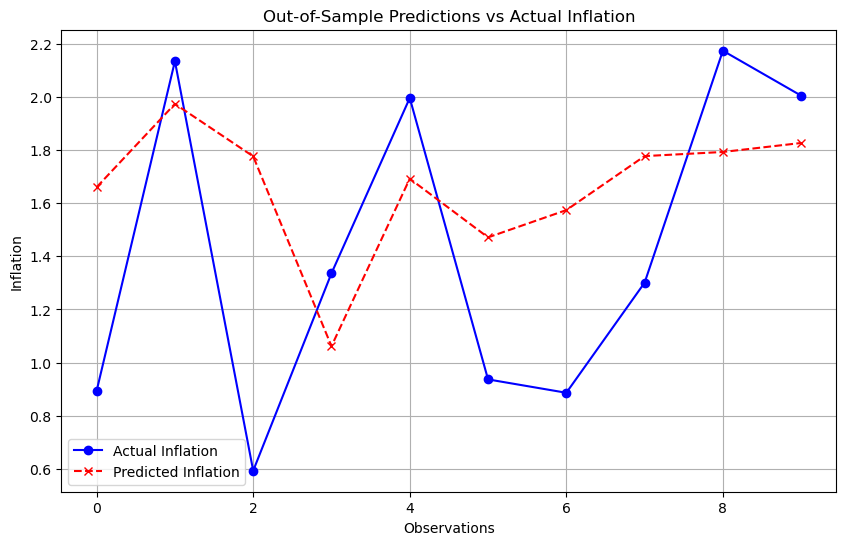

In [34]:
comparison_df = pd.DataFrame({'Actual': y_test2, 'OLS': y_pred2})
comparison_df = comparison_df.reset_index(drop=True)

print('Root Mean Squared Error:', rmse)

plt.figure(figsize=(10, 6))
plt.plot(comparison_df['Actual'], label='Actual Inflation', color='blue', marker='o')
plt.plot(comparison_df['OLS'], label='Predicted Inflation', color='red', linestyle='dashed', marker='x')
plt.title('Out-of-Sample Predictions vs Actual Inflation')
plt.xlabel('Observations')
plt.ylabel('Inflation')
plt.legend()
plt.grid(True)
plt.show()

In [35]:
comparison_df

,Actual,OLS
0,0.893376,1.660576
1,2.135217,1.974333
2,0.592621,1.776728
3,1.336275,1.061716
4,1.996555,1.692538
5,0.936611,1.471541
6,0.886221,1.574288
7,1.300944,1.777706
8,2.174643,1.793260
9,2.005321,1.827144


In [36]:
comparison_df.to_csv('../data/predictions/OLS.csv')